# Benchamrking


In [269]:
import sys
sys.path.append("../")
# import syn data generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from synthetic_data_generation.syn_gyn_module import (
    Metric,
    UnitCov,
    IntCov,
    SyntheticDataModule,
)

from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from causallib.estimation import IPW, Standardization, StratifiedStandardization
from causallib.estimation import AIPW, PropensityFeatureStandardization, WeightedStandardization
from causallib.evaluation import evaluate
from algorithms.snn_biclustering import SNNBiclustering, SNN
from algorithms.fill_tensor_ALS import ALS


In [270]:
def generate_syn_data():

    seed = 1
    np.random.seed(seed)
    # Time
    T = 50

    # Define some metrics
    metric1 = Metric("sales", metric_range=[0, 500])
    metrics = [metric1]

    # Interventions: Daily promotional emails frequency: none, daily, weekly
    num_interventions = 3

    # unit covariates: location and size
    loc = UnitCov("location", categories=["East coast", "West coast", "Midwest"])
    age = UnitCov("age", categories=["<25", "25-35", "35-50", ">50"])
    unit_cov = [loc, age]

    # intervention covariates:
    treatment = IntCov(
        "emails",
        discrete=True,
        categories=["None", "Daily", "Weekly"],
        divisions=3,
        assignment=[0, 1, 2], # Note that the assignments here makes the 
                              # association between no emails and intervention 0, 
                              # daily emails with  intervention 1, etc ..
    )
    int_cov = [treatment]

    # num of units (customer groups)
    N = 100
    # initalize and generate
    data = SyntheticDataModule(
        N,
        T,
        num_interventions,
        metrics,
        unit_cov,
        int_cov,
        freq="1D"
    )

    # generate initial factors
    data.generate_init_factors(trend_coeff = 0.6, lin_tren = True, max_amp_har = 10, min_amp_har= 10, max_periods = 10)

    # Now we will define differen subpopulations andd specific effects on them for each intervention

    # choose sub populations of interest where interventions will have different effects
    subpop1 = lambda: (age.unit_labels == "<25")
    subpop2 = lambda: (loc.unit_labels == "West coast") & (age.unit_labels != "<25")
    subpop3 = lambda: (loc.unit_labels == "East coast") & (age.unit_labels != "<25")
    subpop4 = lambda: (loc.unit_labels == "Midwest") & (age.unit_labels != "<25")

    data.subpopulations_funcs = [subpop1, subpop2, subpop3]

    # We will assume that intervention 1 will incure an increase of 5%-12 in sales for some subpop, and a decrease of 10% in subpop4
    # and intervention 2 will increase 15% in sales for all subpops
    effects = [
        {"metric": metric1, "intervention": 1, "subpop": subpop1, "effect": 0.05},
        {"metric": metric1, "intervention": 1, "subpop": subpop2, "effect": 0.12},
        {"metric": metric1, "intervention": 1, "subpop": subpop3, "effect": 0.12},
        {"metric": metric1, "intervention": 1, "subpop": subpop4, "effect": -0.1},
        {"metric": metric1, "intervention": 2, "subpop": None, "effect": 0.1},
    ]

    data.add_effects(effects)


    period_1 = {"intervention_assignment": "control", "until": T // 4}

    intervention_assignment = "cov_unit"
    selection_subpop = {
        subpop1: [0.3, 0.3, 0.4],
        subpop2: [0.3, 0.4, 0.3],
        subpop3: [0.3, 0.4, 0.3],
        subpop4: [0.3, 0.4, 0.3],
    }
    period_2 = {
        "intervention_assignment": intervention_assignment,
        "until": T ,
        "assignment_subpop": selection_subpop,
    }

    periods = [period_1, period_2]#, period_3]

    return data, periods

## Setup

**Observation**: T measurements of N units for a specific metric $Y$ under one of $I$ interventions. We assume access to one observation per unit and time. 

**Goal**: Predict the metric of interest $Y^i_{n,t}$ for each unit $n\in[N]$, in each timestep $t\in[T]$, under any intervention $i\in [I]$. 

## Baselines

### Simple Averages

#### 1. Average across units (UnitAv)
In this baseline, we will predict the counterfactual for unit $n$ at time $t$ and intervention $i$ as the average across units (donors) who received that intervention at that time. That is:
$$Y^{i}_{n,t} = \frac{\sum_k Y^{i}_{k,t} \mathbf{1}_{Y^{i}_{k,t} is observed}}  {\sum_k  \mathbf{1}_{Y^{i}_{k,t} is observed}} $$

Baseline makes sense when:
1. Units are the same. (implies the effect is the same across units and there is no confounding)
2. The measuerments and treatment effects vary over time.

**Caveat**: If no donors exist at time $t$, the value is imputed by overall average at time $t$.



#### 2. Average across time  (TimeAv)
In this baseline, we will predict the counterfactual for unit $n$ at time $t$ and intervention $i$ as the average across time where we have observed intervention $i$ for unit $n$. That is:
$$Y^{i}_{n,t} = \frac{\sum_{t'} Y^{i}_{n,t'} \mathbf{1}_{Y^{i}_{k,t'} is observed}}  {\sum_{t'} \mathbf{1}_{Y^{i}_{k,t'} is observed}} $$

Baseline makes sense when:
1. Time has no effect. (implies the effect is the same across time)
2. The measuerments and treatment effects vary over units.

**Caveat**: If no measurements exist for unit $n$ with intervention $i$, the value is imputed by the unit overall average. 


### Causal baselines

In these set of baselines, we will also assume access to a unit specific covariates vector $X_i$. The goal of these causal baselines is to estimate the average treatment outcome ($ATO$) or the conditional ATO ($CATO$). 

The ATO is an estimate of:
$$ \sum_{n,t} Y^i_{n,t} $$
Where ad $CATO(i,x)$ is defined analgously for a unit with covariate $x$.


In these baselines, we estimate the counterfactual estimate as:

$$ Y^i_{n,t} =  Y^{\text{observed treatment}}_{n,t} - ATO(\text{observed treatment}) + ATO(i) $$

Below, we list a variety of methods that we use to estimate $ATO$ and $CATO$.

#### 3. Inverse Probability Weighting (IPW).
In this baseline, we estimate the $ATO$ for each intervention using the IPW estimator. We use logistic regression to estimate the propensity.

#### 4. Time indexed IPW (IPW-t).
Same as (3), but here we learn a time-indexed ATO. That is, for each time step, an estimator is trained. 

#### 5. DoublyRobust (DR).
This baseline learns CATO and combines both:
1. A weight model (learned by logistic regression) to estimate propensity;
2. An outcome model (linear regression or randomForestRegressor) that predicts the outcome as a function of treatment, covariates.
The estimator uses importance sampling using the estimated weights when learning the outcome model.

#### 6. DoublyRobust (DR-t).
Same as 5 with here we learn a time-indexed CATO. That is, for each time step, an estimator is trained. 


### Tensor-based baselines
#### 7. ALS
#### 8. SNN
#### 9. SNNBiclustering 

We define all these baselines below

In [259]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from causallib.estimation import IPW, Standardization, StratifiedStandardization
from causallib.estimation import AIPW, PropensityFeatureStandardization, WeightedStandardization
from causallib.evaluation import evaluate
from algorithms.snn_biclustering import SNNBiclustering, SNN
from algorithms.fill_tensor_ALS import ALS

methods = {"SNN": SNN, "SNNB": SNNBiclustering, "ALS":ALS}
def fill_tensor_unit_ave(tensor):
    N, T, I = tensor.shape
    out_tensor = np.array(tensor)
    
    for i in range(I):
        donor_tensor = np.array(tensor[:,:,i])
        recovered_value =  np.nanmean(donor_tensor, axis = 0)
        recovered_value[np.isnan(recovered_value)] = np.nanmean(tensor[:,np.isnan(recovered_value),:], axis = (0,2))
        assert np.isnan(recovered_value).sum() ==0
        assert recovered_value.shape[0] == T
        for n in range(N):
            x = donor_tensor[n,:]
            if np.isnan(x).sum() == 0: continue
            out_tensor[n,np.isnan(x),i] = recovered_value[np.isnan(x)]
    return out_tensor

def fill_tensor_time_ave(tensor):
    N, T, I = tensor.shape
    out_tensor = np.array(tensor)
    
    for i in range(I):
        donor_tensor = np.array(tensor[:,:,i])
        recovered_value =  np.nanmean(donor_tensor, axis = 1)
        recovered_value[np.isnan(recovered_value)] = np.nanmean(tensor[np.isnan(recovered_value),:,:], axis = (1,2))
        assert recovered_value.shape[0] == N
        for t in range(T):
            x = donor_tensor[:,t]
            if np.isnan(x).sum() == 0: continue
            out_tensor[np.isnan(x),t,i] = recovered_value[np.isnan(x)]
    return out_tensor



def mean_baseline(tensor):
    tensor[np.isnan(tensor)] = np.nanmean(tensor)
    return tensor

def what_if(df, tensor, method = "SNN"):
    N, T, I = tensor.shape
    model = methods[method](verbose = False, k_factors = 8)
    model.fit(
                        df=df,
                        unit_column="unit_id",
                        time_column="time",
                        metrics=["sales"],
                        actions=["emails"],
                    )
    indices = [model.actions_dict[action] for action in ["None", "Daily", "Weekly"]]
    _tensor_est = model.get_tensor_from_factors(regime =model.regimes[0])
    tensor_est = _tensor_est[:, :, indices]
    tensor_nans = model.tensor_nans
    mask = tensor_nans.todense()
    tensor_est[mask] = np.nan
    # fill in missing values with unit average across time for each intervention
    for i in range(I):
        donor_tensor = np.array(tensor_est[:,:,i])
        recovered_value =  np.nanmean(donor_tensor, axis = 1)
        assert recovered_value.shape[0] == N
        if np.isnan(donor_tensor).sum() == 0: continue
        for n in range(N):
            for t in range(T):
                if not np.isnan(tensor_est[n,t,i]): continue
                observed_int = np.argmin(np.isnan(tensor_est[n,t,:]))
#                 IATE = np.nanmean(tensor_est[n,:,i] / tensor_est[n,:,observed_int])
                tensor_est[n,t,i] = np.nanmean(tensor[:,:,:])
    return tensor_est, mask

### CAUSAL BASELINES

def ipw_estimator(df, treatment, confounders, outcome, obs):
    # fit weights
    N, T, I,_ = obs.shape
    learner = RandomForestClassifier()
    ipw = IPW(learner)
    X = pd.get_dummies(df[confounders])
    a = df[treatment]
    y = df[outcome]
    
    if len(a.unique()) == 1:
        outcomes =  pd.Series(data = np.ones(I) * y.mean(), index = np.arange(I))
    else:
        ipw.fit(X, a)
        # Estimate average outcome
        outcomes = ipw.estimate_population_outcome(X, a, y)
    tensor_com = np.array(obs[...,0])
    for i in range(I): 
        if i not in outcomes:  outcomes[i] = outcomes.mean()
    for i in range(I):
        tensor_com_i = tensor_com[...,i]
        for j in range(I):
            if i == j: continue
            tensor_com[np.isnan(tensor_com_i),i] = obs[np.isnan(tensor_com_i) ,j, 0] + (outcomes[i] - outcomes[j])
    
    return tensor_com

def dr_estimator(df, treatment, confounders, outcome, obs, unit, outcome_model = RandomForestRegressor()  ):
    # fit weights
    N, T, I,_ = obs.shape
    learner = RandomForestClassifier()
    ipw = IPW(learner)
    std = Standardization(outcome_model)
    dr = WeightedStandardization(std, ipw)
    X = pd.get_dummies(df[confounders])
    a = df[treatment].rename("treatment")
    y = df[outcome].rename("outcome")
    if len(a.unique()) == 1:
        ind_outcomes =  pd.DataFrame(data = np.ones([N,I]) * y.mean(), index = np.arange(N))
    else:
        dr.fit(X, a, y)
        # Estimate average outcome
        ind_outcomes = dr.estimate_individual_outcome(X, a)
        ind_outcomes = pd.concat([ind_outcomes, df[unit]], axis = 1).groupby(unit).mean()
    
    tensor_com = np.array(obs[...,0])
    for i in range(I): 
        if i not in ind_outcomes:  ind_outcomes[i] = ind_outcomes.mean(1)
    for n in range(N):
        for i in range(I):
            tensor_com_in = tensor_com[n,:,i]
            for j in range(I):
                if i == j: continue
                tensor_com[n, np.isnan(tensor_com_in),i] = obs[n, np.isnan(tensor_com_in) ,j, 0] + (ind_outcomes.loc[n, i] - ind_outcomes.loc[n, j])
    
    return tensor_com

def ipw_estimator_t(df, time, treatment, confounders, outcome, obs):
    N, T, I, _ = obs.shape
    tensor_com = np.array(obs[...,0])
    timestamps = np.sort(pd.unique(df.time))
    for t in range(T):
        df_t = df.loc[df[time] == timestamps[t]]
        assert df_t.shape[0] > 0
        tensor_com[:,t:t+1,:] = ipw_estimator(df_t, treatment, confounders, outcome, obs[:,t:t+1, :, :])
    return tensor_com
    
def dr_estimator_t(df, time, treatment, confounders, outcome, obs, unit, outcome_model = RandomForestRegressor()):
    N, T, I, _ = obs.shape
    tensor_com = np.array(obs[...,0])
    timestamps = np.sort(pd.unique(df.time))
    for t in range(T):
        df_t = df.loc[df[time] == timestamps[t]]
        assert df_t.shape[0] > 0
        tensor_com[:,t:t+1,:] = dr_estimator(df_t, treatment, confounders, outcome, obs[:,t:t+1, :, :], unit, outcome_model = outcome_model)
    return tensor_com


In [260]:
# benchmark code
def benchmark(df, obs, tensor):
    ### Avg baselines
    ten_n = fill_tensor_unit_ave(np.array(obs[...,0]))
    ten_t = fill_tensor_time_ave(np.array(obs[...,0]))
    ten_mean = mean_baseline(np.array(obs[...,0]))
    
    ### Causal baselines
    tensor_ate = causal_baseline_ATE(
      df, treatment = "intervention", 
      confounders = ["age", "location"],
      outcome = "sales", 
      obs = obs,
    )

    tensor_cate = causal_baseline_CATE(
          df, treatment = "intervention", 
          confounders = ["age", "location"],
          outcome = "sales", 
          obs = obs,
          unit = "unit_id"
    )
    
    tensor_cate_p = causal_baseline_CATE(
          df, treatment = "intervention", 
          confounders = ["location"],
          outcome = "sales", 
          obs = obs,
          unit = "unit_id"
    )
    
    tensor_cate_linear = causal_baseline_CATE(
          df, treatment = "intervention", 
          confounders = ["age", "location"],
          outcome = "sales", 
          obs = obs,
          unit = "unit_id",
        outcome_model = LinearRegression()
    )

    tensor_ate_t = causal_baseline_time_indexed(
          df, treatment = "intervention", 
          confounders = ["age", "location"],
          outcome = "sales", 
          obs = obs,
          time = "time"
    )

    tensor_cate_t = time_indexed_CATE(
          df, treatment = "intervention", 
          confounders = ["age", "location"],
          outcome = "sales", 
          obs = obs,
          time = "time",
          unit = "unit_id"
    )
    
    tensor_cate_t_p = time_indexed_CATE(
          df, treatment = "intervention", 
          confounders = ["location"],
          outcome = "sales", 
          obs = obs,
          time = "time",
          unit = "unit_id"
    )
    tensor_cate_t_linear = time_indexed_CATE(
          df, treatment = "intervention", 
          confounders = ["age", "location"],
          outcome = "sales", 
          obs = obs,
          time = "time",
          unit = "unit_id",
          outcome_model = LinearRegression()
        
    )
    
    
    # What-if baselines
    tensor_est, mask = what_if(df, obs[...,0], method = "SNN")
    tensor_est_SNNB, mask = what_if(df, obs[...,0], method = "SNNB")
    tensor_est_ALS, _ = what_if(df, obs[...,0], method = "ALS")
    
    # Estimate Errors
    names = ["SNN", "SNN_Biclustering", "ALS", 
             "time_ave", "unit_ave", "mean", 
             "IPW", "DR (RF)","DR (LR)", "DR (RF, partial cov)",
             "IPW-t",  "DR-t (RF)", 
             "DR-t (LR)", "DR-t (RF, partial cov)"]
    estimates = [tensor_est,
                 tensor_est_SNNB,
                 tensor_est_ALS,
                 ten_n, ten_t,
                 ten_mean,
                 tensor_ate,
                 tensor_cate,
                 tensor_cate_linear,
                 tensor_cate_p,
                 tensor_ate_t, 
                 tensor_cate_t,
                 tensor_cate_t_linear,
                 tensor_cate_t_p,
                 ]
    df_res = pd.DataFrame(columns = ("RMSE", "R2"), index = names)
    nan_mask = np.isnan(obs[...,0])
    true = tensor[nan_mask,0].flatten()
    for i in range(len(names)):
        estimate = estimates[i][nan_mask].flatten()
        df_res.loc[names[i]] = [rmse(estimate, true), r2_score(true, estimate)]
    return df_res

def rmse(t1, t2):
    return np.sqrt(np.square(t1-t2).mean())


## Generate Synthetic Data

#### Generate data

In [261]:
data, periods = generate_syn_data()
tensor, full_df = data.generate([0,T-1])
ss_tensor, df = data.auto_subsample(periods, tensor, full_df)
obs = np.full(tensor.shape, np.nan)
obs[data.mask == 1] = tensor[data.mask ==1]


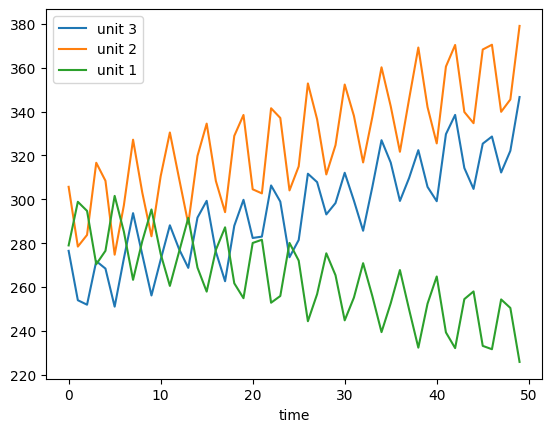

In [262]:
plt.plot(tensor[0,:,:,0])
plt.xlabel('time')
plt.legend({"unit 1", "unit 2", "unit 3"})


## Run benchmarking

In [263]:
df_res = benchmark(df, obs, tensor)

/var/folders/jg/bh57brfs2_985glc7khw9sch0000gn/T/ipykernel_93656/185479294.py:16: RuntimeWarning: Mean of empty slice
  recovered_value =  np.nanmean(donor_tensor, axis = 0)
/var/folders/jg/bh57brfs2_985glc7khw9sch0000gn/T/ipykernel_93656/185479294.py:32: RuntimeWarning: Mean of empty slice
  recovered_value =  np.nanmean(donor_tensor, axis = 1)
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureW

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted wi

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted wi

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted wi

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted wi

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted wi

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted wi

Generated 6 clusters


/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/benchmarking/../algorithms/fill_tensor_base.py:357: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  metric_matrix_df = df.pivot(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/benchmarking/../algorithms/fill_tensor_base.py:371: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  current_true_intervention_assignment_matrix = df.pivot(


<AxesSubplot: >

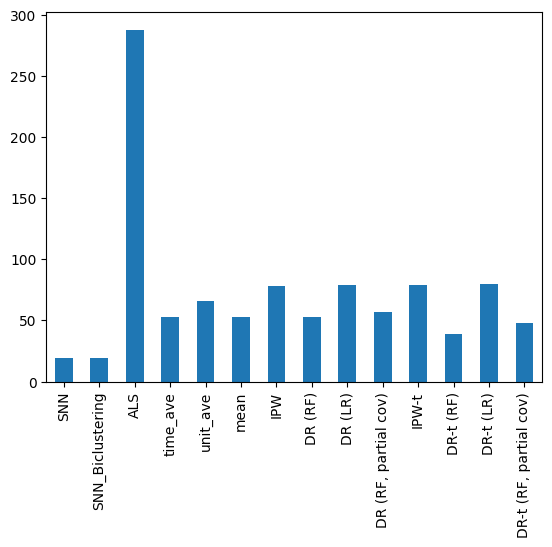

In [264]:
df_res.iloc[:,:].RMSE.plot.bar()

In [265]:
df_res.sort_values("RMSE")

,RMSE,R2
SNN,18.855836,0.865559
SNN_Biclustering,18.855836,0.865559
DR-t (RF),39.291226,0.416245
"DR-t (RF, partial cov)",47.931692,0.13127
time_ave,52.406037,-0.038489
mean,52.407776,-0.038558
DR (RF),52.751728,-0.052235
"DR (RF, partial cov)",57.297559,-0.241399
unit_ave,65.802115,-0.637265
IPW,78.558721,-1.333609


# Draft

In [266]:
N, T, I, _ = tensor.shape
model = SNN(verbose = False, k_factors = 8)
model.fit(
                    df=df,
                    unit_column="unit_id",
                    time_column="time",
                    metrics=["sales"],
                    actions=["emails"],
                )
indices = [model.actions_dict[action] for action in ["None", "Daily", "Weekly"]]
_tensor_est = model.get_tensor_from_factors(regime =model.regimes[0])
tensor_est = _tensor_est[:, :, indices]
tensor_nans = model.tensor_nans
mask = tensor_nans.todense()
tensor_est[mask] = np.nan



/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/benchmarking/../algorithms/fill_tensor_base.py:357: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  metric_matrix_df = df.pivot(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/benchmarking/../algorithms/fill_tensor_base.py:371: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  current_true_intervention_assignment_matrix = df.pivot(


In [267]:
from algorithms.als import AlternatingLeastSquares
ALS = AlternatingLeastSquares(k_factors = 8)
ALS.fit(tensor[...,0])
tensor_hat = ALS.predict()


In [268]:
np.square(tensor_hat-tensor[...,0]).mean()

2.701885259911667e-12

In [276]:
import cmath
a = complex(1,1)
b = complex(1,-1)
a/b

1j

In [282]:
(1/(1-0.6/0.4))**4

16.00000000000003